In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score
from utils.text_preprocessing import full_preprocess
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import os
import IPython
from torch.optim.lr_scheduler import ExponentialLR
from utils.get_embeddings import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
df = load_df(os.path.join('data', 'train_spam.csv'))
df

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


Получим эмбеддинги с берта

In [4]:
embeddings = generate_embeddings(df, 'bert-base-uncased')

  0%|          | 0/16278 [00:00<?, ?it/s]

Запишем индексы, чтобы посмотреть потом, на каких примерах модель ошибается

In [5]:
idx = torch.arange(0, len(embeddings['embedding']))

In [6]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(embeddings['embedding'], embeddings['label'], idx,
                                                    test_size=0.33, random_state=42)

In [7]:
def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        data=X_train,
        label=y_train,
        )
    test_pool = Pool(
        data=X_test,
        label=y_test,
        )

    catboost_default_params = {
        'iterations': 1000,
        'loss_function': 'Logloss',
        'l2_leaf_reg': 5,
        'learning_rate': 0.3,
        'eval_metric': 'AUC',
        'task_type': 'GPU',
        'depth': 8,
        'langevin': True,
        'auto_class_weights': 'Balanced',
        'score_function': 'NewtonCosine'
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

In [8]:
model = fit_catboost(X_train.numpy(), X_test.numpy(), y_train, y_test)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9149475	best: 0.9149475 (0)	total: 148ms	remaining: 2m 28s
100:	test: 0.9875267	best: 0.9875267 (100)	total: 15.1s	remaining: 2m 14s
200:	test: 0.9888188	best: 0.9888188 (200)	total: 29.2s	remaining: 1m 55s
300:	test: 0.9894938	best: 0.9894938 (300)	total: 43.5s	remaining: 1m 41s
400:	test: 0.9897898	best: 0.9897898 (400)	total: 56.8s	remaining: 1m 24s
500:	test: 0.9899532	best: 0.9899532 (500)	total: 1m 10s	remaining: 1m 9s
600:	test: 0.9900572	best: 0.9900658 (595)	total: 1m 23s	remaining: 55.4s
700:	test: 0.9901426	best: 0.9901426 (700)	total: 1m 36s	remaining: 41.3s
800:	test: 0.9902247	best: 0.9902310 (795)	total: 1m 50s	remaining: 27.4s
900:	test: 0.9902629	best: 0.9902695 (880)	total: 2m 3s	remaining: 13.6s
999:	test: 0.9903463	best: 0.9903463 (999)	total: 2m 16s	remaining: 0us
bestTest = 0.9903462529
bestIteration = 999


In [9]:
y_pred = model.predict(X_test.numpy())

На тесте модель ошибается всего на 219 примерах

In [10]:
idx_test[y_pred != y_test].shape[0]

219

In [11]:
model_prediction = model.predict(embeddings['embedding'].numpy())

In [12]:
df['model_prediction'] = model_prediction
df['model_prediction'] = df['model_prediction'].apply(lambda x: {0: 'ham', 1: 'spam'}[x])

In [13]:
df[df['text_type'] != df['model_prediction']]

,text_type,text,model_prediction
31,spam,i cant still believe i made it in here after m...,ham
33,ham,iblong2u spirituality is for the rich as well ...,spam
65,spam,hello i need to sell my op id ani one need dm ...,ham
68,ham,if condoms were to use well advertiesed brand ...,spam
150,spam,software taking a bite out of your budget try ...,ham
...,...,...,...
16021,spam,have a good day i really need help my facebook...,ham
16156,spam,you have an important customer service announc...,ham
16224,spam,would you like to know what the powerball winn...,ham
16229,ham,url url date 1635465 1635465 1635465t1635465 1...,spam


Попробуем теперь предсказывать с помощью нейросети

In [14]:
class Dataset_class(torch.utils.data.Dataset):

  def __init__(self, X, y, scale_data=True):
    
    self.y = y
    if scale_data:
       scaler = StandardScaler()
       self.X = scaler.fit_transform(X)
    else:
       self.X = X
      

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [15]:
class MLP(nn.Module):

  def __init__(self, emb_size, p=0.35):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(emb_size, 512),
      nn.ReLU(),
      nn.BatchNorm1d(512),
      nn.Dropout(p),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.BatchNorm1d(256),
      nn.Linear(256, 1)
      )

  def forward(self, x):
    return self.layers(x)

In [16]:
dataset = Dataset_class(X_train, y_train, scale_data=False)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [17]:
mlp = MLP(emb_size=embeddings['embedding'].shape[1], p=0.35)
mlp.to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=5e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)

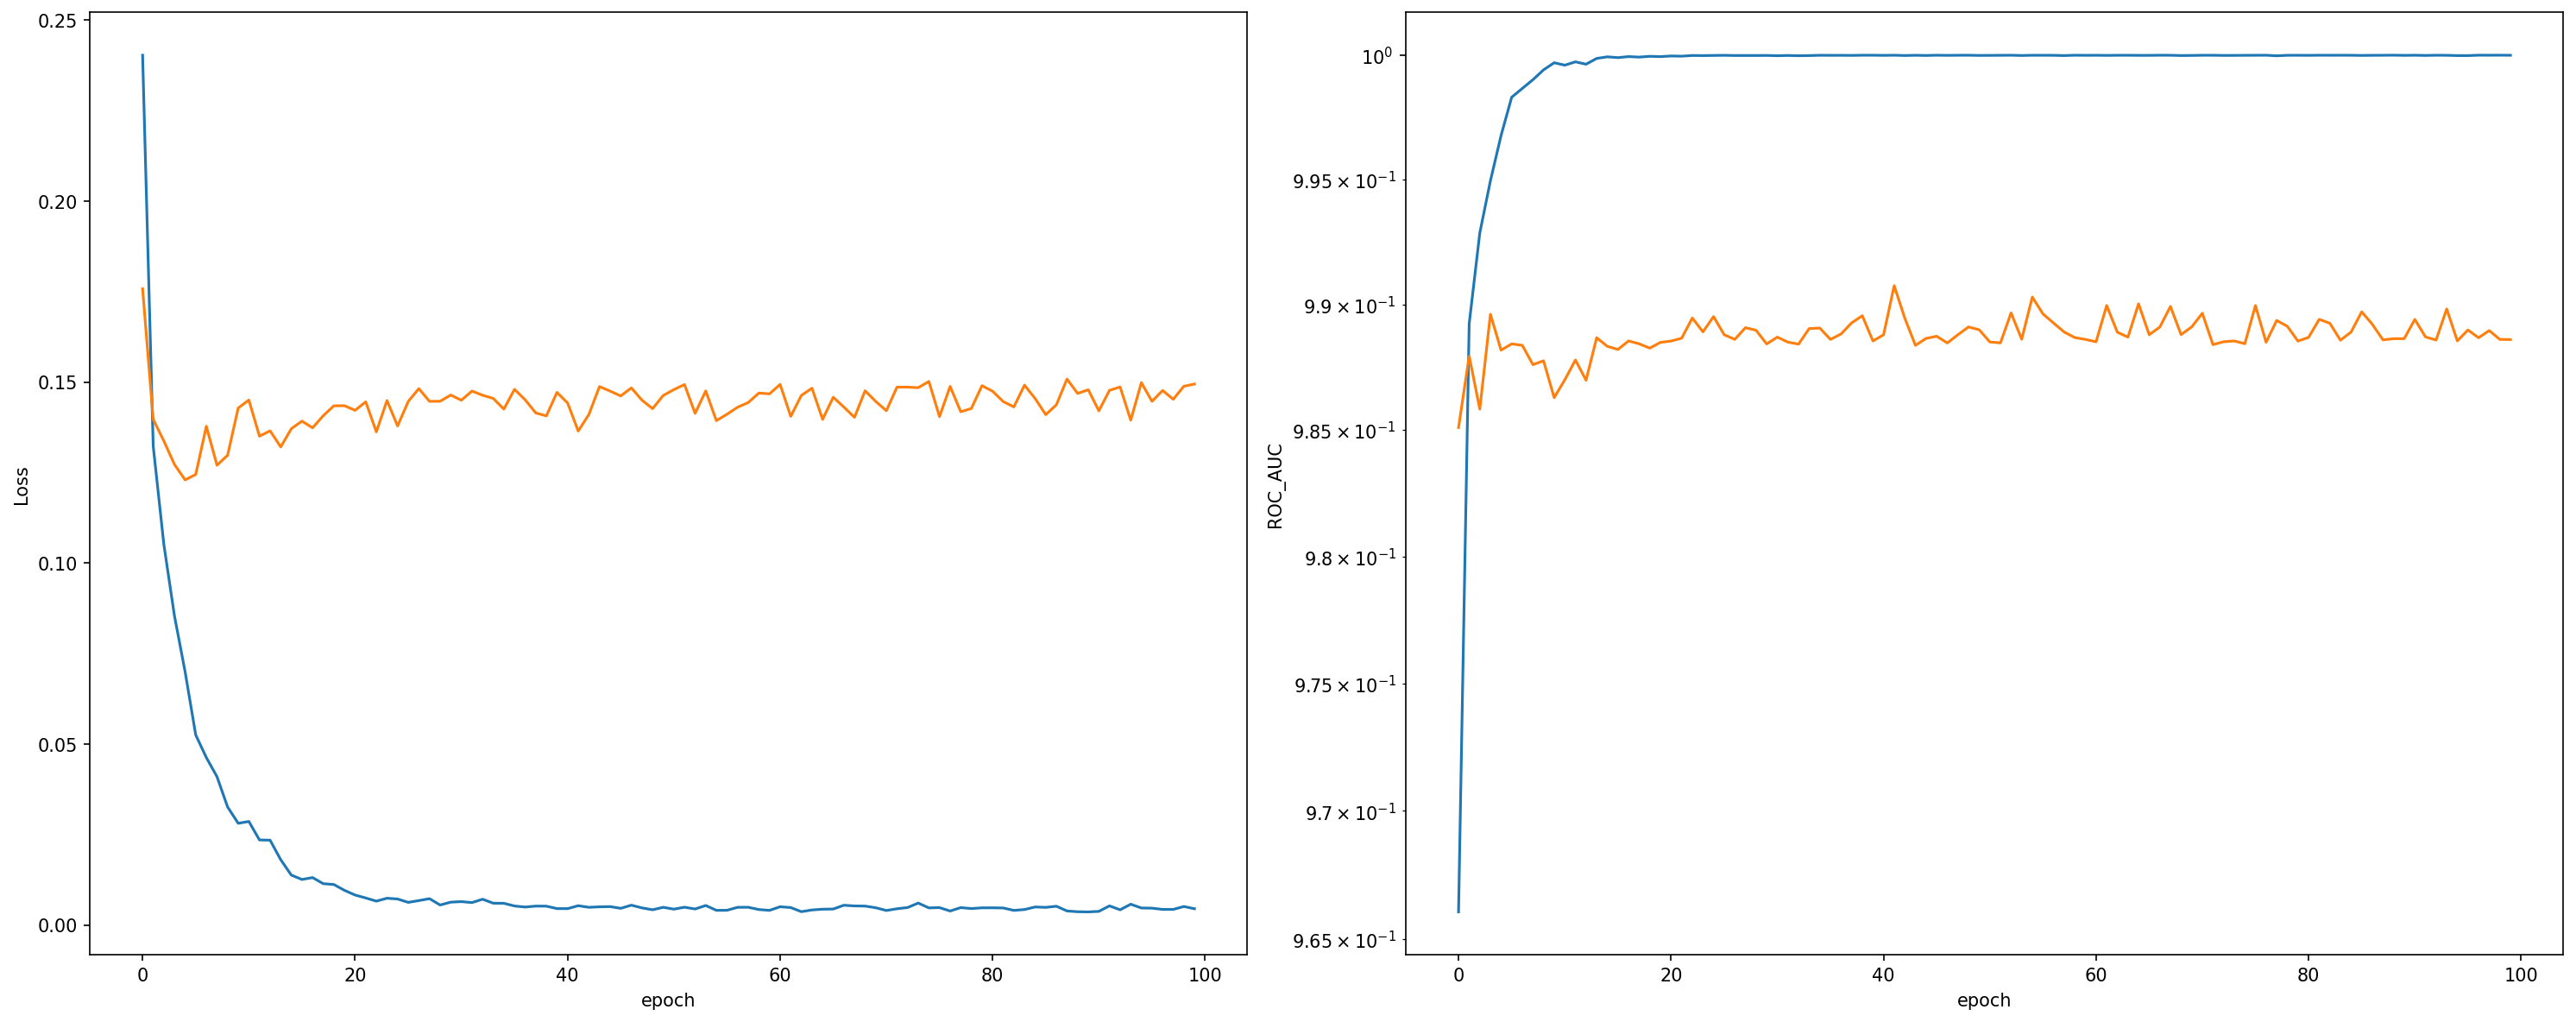


Loss after epoch 100: train=0.004480443429201841, test=0.14946412776150036

AUC after epoch 100: train=0.999996649983585, test=0.9886044595118941


In [18]:
loss_train = []
loss_test = []
metric_train = []
metric_test = []
EPOCH_NUM = 100
for epoch in tqdm(range(0, EPOCH_NUM)):
    IPython.display.clear_output(wait=True)
    mlp.train()
    loss_epoch = []
    auc_train_epoch = []
    for i, data in enumerate(trainloader, 0):
      
          inputs, targets = data
          inputs, targets = inputs.float().to(device), targets.float().to(device)
          targets = targets.reshape((targets.shape[0], 1))
          
          optimizer.zero_grad()
          
          outputs = mlp(inputs)
          try:
              roc = roc_auc_score(targets.cpu().detach(), outputs.cpu().detach())
              auc_train_epoch.append(roc)
          except ValueError:
              pass
          loss = loss_function(outputs, targets)
          loss_epoch.append(loss.cpu().detach().numpy())
          loss.backward()

          optimizer.step()

    loss_train.append(np.mean(loss_epoch))
    metric_train.append(np.mean(auc_train_epoch))
    best_metric = 0
    mlp.eval()
    with torch.no_grad():
        pred = mlp(X_test.float().to(device))
        loss_test_item = loss_function(pred.flatten().cpu(), torch.tensor(y_test, dtype=float)).item()
    roc_auc = roc_auc_score(y_test, pred.cpu())
    if roc_auc >= best_metric:
        best_metric = roc_auc
        torch.save(mlp.state_dict(), os.path.join('models', f'bert_emb.pt'))
    metric_test.append(roc_auc)
    loss_test.append(loss_test_item)
    scheduler.step()
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(20, 8), dpi=150)
    ax[0].plot(range(epoch+1), loss_train)
    ax[0].plot(range(epoch+1), loss_test)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('Loss')
    ax[1].plot(range(epoch+1), metric_train)
    ax[1].plot(range(epoch+1), metric_test)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('ROC_AUC')
    plt.yscale('log')
    plt.show()
    print(f'\nLoss after epoch {epoch+1}: train={loss_train[-1]}, test={loss_test[-1]}')
    print(f'\nAUC after epoch {epoch+1}: train={metric_train[-1]}, test={metric_test[-1]}')


In [19]:
np.max(metric_test)

0.9907522074913784

In [20]:
best_model = MLP(emb_size=embeddings['embedding'].shape[1], p=0.35)
best_model.load_state_dict(torch.load(os.path.join('models', 'bert_emb.pt')))

<All keys matched successfully>

In [21]:
def predict(model, X):
    global device
    model.to(device)
    X = X.to(device)
    model.eval()
    with torch.no_grad():
        logits = model(X)
        prob = torch.sigmoid(logits)
    return prob

In [22]:
p = predict(best_model, embeddings['embedding']).flatten().cpu().numpy()

In [23]:
pred_labels = (p > 0.5).astype(int)

In [24]:
df['model_prediction'] = pred_labels
df['model_prediction'] = df['model_prediction'].apply(lambda x: {0: 'ham', 1: 'spam'}[x])

In [25]:
df[df['text_type'] != df['model_prediction']]

,text_type,text,model_prediction
65,spam,hello i need to sell my op id ani one need dm ...,ham
68,ham,if condoms were to use well advertiesed brand ...,spam
168,ham,stuart little 2 2021 kannada chukki movies hdt...,spam
170,ham,freemasonry,spam
217,spam,i have a life changing experience with the hel...,ham
...,...,...,...
15690,spam,hello i wanna sell a group of 50 investors,ham
15898,ham,ms 150 dear friends and family on april 15 and...,spam
16021,spam,have a good day i really need help my facebook...,ham
16156,spam,you have an important customer service announc...,ham


Получилось получше, чем у кэтбуста

Сравнивая с остальными моделями, последний подход как по мне дает лучший результат, поэтому использую его для предсказания на тесте

In [26]:
test_df = load_df(os.path.join('data', 'test_spam.csv'))
test_df['text_type'] = 'ham' # просто чтобы не менять функцию, все равно этот столбец нигде не будет использоваться
test_df

,text,text_type
0,j jim whitehead ejw cse ucsc edu writes j you ...,ham
1,original message from bitbitch magnesium net p...,ham
2,java for managers vince durasoft who just taug...,ham
3,there is a youtuber name saiman says,ham
4,underpriced issue with high return on equity t...,ham
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,ham
4066,baylor enron case study cindy yes i shall co a...,ham
4067,boring as compared to tp,ham
4068,hellogorgeous hows u my fone was on charge lst...,ham


In [27]:
test_emb = generate_embeddings(test_df, 'bert-base-uncased')

  0%|          | 0/4070 [00:00<?, ?it/s]

In [28]:
test_emb['embedding']

tensor([[ 0.0121,  0.0475,  0.4826,  ..., -0.1841,  0.0355,  0.0804],
        [ 0.1560,  0.2791,  0.2990,  ..., -0.3028, -0.0590,  0.1233],
        [-0.2026,  0.0858,  0.3223,  ..., -0.1724, -0.0941,  0.0045],
        ...,
        [ 0.0591, -0.3371,  0.0155,  ...,  0.1880,  0.0742,  0.5097],
        [-0.4426,  0.0634,  0.8331,  ..., -0.4056, -0.0887,  0.3124],
        [-0.1112,  0.1487,  0.3083,  ..., -0.0370,  0.0165, -0.0039]])

In [29]:
test_scores = predict(best_model, test_emb['embedding']).flatten().cpu().numpy()
test_df['score'] = test_scores
test_df.drop(['text_type'], axis=1, inplace=True)

In [30]:
test_df

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,0.000077
1,original message from bitbitch magnesium net p...,0.000502
2,java for managers vince durasoft who just taug...,0.000315
3,there is a youtuber name saiman says,0.000002
4,underpriced issue with high return on equity t...,0.999966
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,0.011536
4066,baylor enron case study cindy yes i shall co a...,0.000029
4067,boring as compared to tp,0.000080
4068,hellogorgeous hows u my fone was on charge lst...,0.000101


In [31]:
test_df.to_csv(os.path.join('data', 'test_preds.csv'))